# Deep learning image caption generator

In [1]:
import os
import pickle
from tqdm.notebook import tqdm
import numpy as np

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #For etracting features from the images
from tensorflow.keras.preprocessing.image import load_img, img_to_array #for img conversion to array of num
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
base_dir = 'C:\\Users\\Biancaa. R\\lumin_eye'
working_dir = 'C:\\Users\\Biancaa. R\\lumin_eye'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
# feature extraction:
features={}
dir=os.path.join(base_dir,"images")
for img_name in tqdm(os.listdir(dir)):
    img_path=dir+"/"+img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [25]:
F=open(os.path.join(working_dir,"features.pkl"),'wb')
pickle.dump(features,F)
F.close()
#reading the file for extracting the features:

In [23]:
F=open(os.path.join(working_dir,"features.pkl"),'rb')
features=pickle.load(F)
F.close()

In [5]:
F=open(os.path.join(working_dir,"features.txt"),'rb')
features=F.read()
F.close()
# another copy of the file as txt

In [16]:
features
#perfect
#Saving them in a file as I dont have 81 mins everyday :/

{'1000268201_693b08cb0e': array([[2.5076475, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.        , 0.        , 0.49410748, ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[1.4937079, 0.       , 0.5356841, ..., 2.3154142, 3.7418418,
         0.       ]], dtype=float32),
 '1003163366_44323f5815': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1007129816_e794419615': array([[0.        , 0.09227571, 0.        , ..., 0.        , 0.        ,
         0.06529319]], dtype=float32),
 '1007320043_627395c3d8': array([[0.       , 0.       , 0.       , ..., 0.       , 3.3386445,
         0.       ]], dtype=float32),
 '1009434119_febe49276a': array([[2.096293 , 2.119319 , 3.562437 , ..., 0.6426412, 2.714651 ,
         0.       ]], dtype=float32),
 '1012212859_01547e3f17': array([[0.        , 0.        , 0.98737085, ..., 0.        , 1.4932492 ,
         0.86128

In [6]:
#Reading the value of the captions:
with open(os.path.join(base_dir, 'captions.txt'), 'r') as f:
    next(f) #ignoring the first line of data
    captions_doc = f.read()

In [70]:
# Creating a mapping from the image to the captions:

mapping={}

#processing the lines:
for line in tqdm(captions_doc.split("\n")):
    tokens=line.split(",")
    #splitting the line available to words
    if len(line)<2:
        continue
        # If the len of line<2 it means the line has no img name,caption parts
    image_id,caption=tokens[0],tokens[1:]
    #As there are multiple caps
    image_id=image_id.split(".")[0]
    #no one wants the extension
    caption=" ".join(caption)
    """Since there are single images with multiple captions we dont want multiple keys with the same image name """
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [71]:
print(len(mapping))
#mapping['667626_18933d713e']
mapping['3637013_c675de7705']
#cool

8091


["A couple stands close at the water 's edge .",
 'The two people stand by a body of water and in front of bushes in fall .',
 'Two people hold each other near a pond .',
 'Two people stand by the water .',
 'Two people stand together on the edge of the water on the grass .']

In [53]:
for key,captions in mapping.items():
    for i in range(len(captions)): #plural here
        caption=captions[i]
        #taking them 1 at a time
        caption=caption.lower()
        #removing special characters,numbers
        #caption=caption.replace('[^A-Za-z]'," ")
        caption=caption.replace("<start>","")
        caption=caption.replace("<stop>","")
         #Adding starts and end tags to the model
        #caption='<start> '+" ".join([word for word in caption.split() if len(word)>1]) +'<stop>'
        #captions[i]=caption
            

In [76]:
#Preprocessing the image:

def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)): #plural here
            caption=captions[i]
            #taking them 1 at a time
            caption=caption.lower()
            #removing special characters,numbers
            caption=caption.replace('[^A-Za-z]'," ")
            caption=caption.replace("\s+"," ")
            #Removing possible changes
            caption=caption.replace("<start>","")
            caption=caption.replace("<stop>","")
            caption=caption.replace('startseq',' ')
            caption=caption.replace('endseq',' ')
            #Adding starts and end tags to the model
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1]) +' endseq'
            captions[i]=caption
            

In [77]:
clean(mapping) #calling the function
mapping['3637013_c675de7705']

["startseq couple stands close at the water 's edge endseq",
 'startseq the two people stand by body of water and in front of bushes in fall endseq',
 'startseq two people hold each other near pond endseq',
 'startseq two people stand by the water endseq',
 'startseq two people stand together on the edge of the water on the grass endseq']

In [78]:
#collecting all the captions together

all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [59]:
#tokenizing the text:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

#Finding the maximum length of line in the data for padding in the model
max_length=max(len(caption.split())for caption in all_captions)
print(max_length)

8483
34


In [60]:
# Test train splitting of the image:

image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]


In [79]:
#Creating datagenerator to get data in batches to avoid session clashes
def datagenerator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    #loop over images
    x1,x2,y=[],[],[]
    n=0
    while True:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            #processing each caption:
            for caption in captions:
                seq=tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0] #padding the input sequence so all the input sequences has the size of the longest sentence
                    #encoding the output sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]     
                    #appending the image features in x1
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    #Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.
                    y.append(out_seq)

                if n==batch_size:
                    x1=np.array(x1)    
                    x2=np.array(x2)
                    y=np.array(y)
                    yield [x1,x2],y
                    x1,x2,y=[],[],[]
                    n=0

In [81]:
#Model creation :/
"""inputs1 =Input(shape=(4096,)) #the value we got from the vgg16 model
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)"""

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [82]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 810s 4s/step - loss: 2.3898


In [83]:
# save the model
model.save('model1.h5')
#the prev epoch took 304 mins 40 s
# this epoch took 304 mins 38 sec

d:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [84]:
from tensorflow import lite,keras
#converter =lite.TFliteConverter.from_keras_model(model)
model=keras.models.load_model("model1.h5")
converter = lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS, lite.OpsSet.SELECT_TF_OPS]
# Converting a SavedModel to a TensorFlow Lite model.
#converter = lite.TFLiteConverter.from_saved_model("C:\\Users\\Biancaa. R\\lumin_eye\\model1.h5")
tflite_model = converter.convert()
#converter.optimizations = [lite.Optimize.DEFAULT]
#tflite_model = converter.convert()
F=open('model1.tflite','wb')
F.write(tflite_model)
F.close()

INFO:tensorflow:Assets written to: C:\Users\BIANCA~1.R\AppData\Local\Temp\tmp30c15o87\assets


INFO:tensorflow:Assets written to: C:\Users\BIANCA~1.R\AppData\Local\Temp\tmp30c15o87\assets


In [85]:
from tensorflow import keras
model=keras.models.load_model("model1.h5")

In [86]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [87]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)#[0]
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq' or word==' endseq':
            break
    return in_text

In [88]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.221587
BLEU-2: 0.117571


In [90]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq dog is sniffing the camera on the sidewalk with something in its mouth and bigger dog follows him in its mouth and black dog walks on the sidewalk beside him nearby lake nearby water


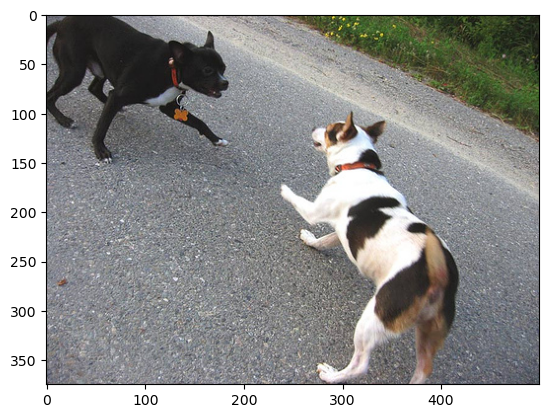

In [91]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq soccer player in blue is chasing after the player in black and white endseq
startseq the girl in the white strip is falling down as the girl in the blue strip challenges for the soccer ball endseq
startseq the girls are playing soccer endseq
startseq two women in soccer uniforms playing soccer endseq
startseq two young women on different teams are playing soccer on field endseq
--------------------Predicted--------------------
startseq rugby players struggling for the ball while third team member is being watched by another man in blue shorts keeps the ground below him in red and white shorts and black team member in


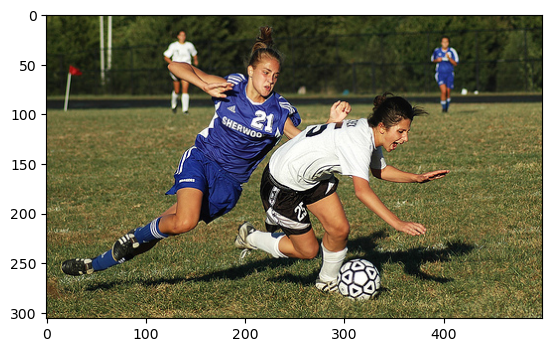

In [94]:
generate_caption("47871819_db55ac4699.jpg")

---------------------Actual---------------------
startseq boy with stick kneeling in front of goalie net endseq
startseq child in red jacket playing street hockey guarding goal endseq
startseq young kid playing the goalie in hockey rink endseq
startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq
startseq "hockey goalie boy in red jacket crouches by goal with stick ." endseq
--------------------Predicted--------------------
startseq hockey goalie in the dot uniform is guarding the goal net to another man in red jacket and black shoes on the net with his head on the net and another man in red


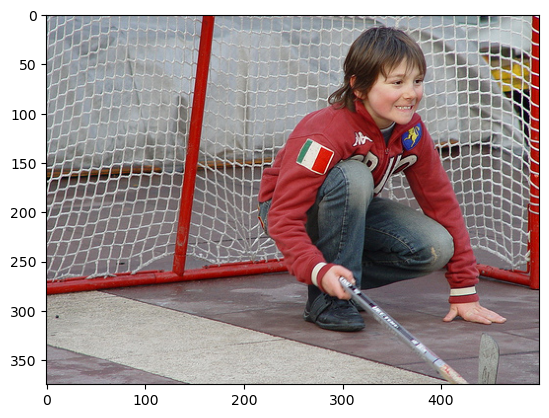

In [95]:
generate_caption("103106960_e8a41d64f8.jpg")

In [92]:
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [93]:
image_path = "C:\\Users\\Biancaa. R\\Downloads\\9648fcf16161b423d0c4df7f8c6ba150.jpg"
#"C:\Users\Biancaa. R\Downloads\WhatsApp Image 2023-11-09 at 4.02.42 PM.jpeg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

"startseq high in the air while another reads to the ground and it looks like he 's hand and the other is both 's other men are sitting on the ground and one reads it"